<a href="https://colab.research.google.com/github/martinfinis/HelloCodeSchoolProject/blob/master/Quest_Stock_Prediction_Martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction 
In this exercise you will work with stock market data. We use the data available at [Yahoo Finance](https://finance.yahoo.com/quote/DAX/history?period1=1478390400&period2=1604534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)
You will build sequential models to predict the variations for Global X DAX Germany ETF (DAX). The goal is to predict whether the stock value is higher or lower than its actual value of previous day.

for more infromaiton

https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f

# https://drive.google.com/file/d/130vrhYjSLtkzbHLrPLiSr5I0jW8LLKo3/view?usp=sharing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

### Loading and Preprocessing Data

In [2]:
import os
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# begin function definitions
def download_file(url: str, local_file_name: str, overwrite: bool =False):
  '''
    Downloads a file from an url in the www to the local file system.
    Credits go to Andras.
    Params
      url: str -> url of file
      local_file_name: str -> name of file in local file system
      overwrite: bool -> False (Default), doesn't overwrite existing local file.
                         True: overwrite existing local file.
  '''
  f_id = url.split('/')[-2]
  if not os.path.exists(local_file_name) or overwrite:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    downloaded = drive.CreateFile({'id': f_id})
    downloaded.GetContentFile(local_file_name)
# end function definitions

In [3]:
link = 'https://drive.google.com/file/d/130vrhYjSLtkzbHLrPLiSr5I0jW8LLKo3/view?usp=sharing'
name = 'data.zip'#'small_vocab_en.csv.zip'

# download url to local file
download_file(link, name,overwrite=True)

In [4]:
!unzip data.zip -d my_data

Archive:  data.zip
replace my_data/data/dax_test_2019.csv.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
training_data = pd.read_csv("/content/my_data/data/dax_train_2019.csv.txt", sep=",")
print(f"Training data column info:\n {training_data.dtypes}")
print(f"Training data shape is {training_data.shape}")

Training data column info:
 date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Training data shape is (644, 7)


In [6]:
testing_data = pd.read_csv("/content/my_data/data/dax_test_2019.csv.txt", sep=",")
print(f"Testing data column info:\n {training_data.dtypes}")
print(f"Testing data shape is {training_data.shape}")

Testing data column info:
 date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Testing data shape is (644, 7)


In [7]:
testing_data

,date,open,high,Low,close,adj_close,volume
0,2019-06-03,25.660000,25.830000,25.650000,25.825001,24.876635,10700
1,2019-06-04,26.150000,26.166000,25.889999,26.090000,25.131905,10400
2,2019-06-05,26.115999,26.115999,26.115999,26.115999,25.156948,100
3,2019-06-06,26.326000,26.326000,26.326000,26.326000,25.359238,400
4,2019-06-07,26.549999,26.600000,26.223000,26.540001,25.565380,5300
...,...,...,...,...,...,...,...
143,2019-12-24,27.990000,27.990000,27.990000,27.990000,27.668003,0
144,2019-12-26,27.980000,28.190001,27.980000,28.055000,27.732258,175900
145,2019-12-27,28.260000,28.299999,28.139999,28.139999,27.816278,2900
146,2019-12-30,28.040001,28.040001,27.700001,27.700001,27.384260,4400


In [8]:
len(testing_data)
testing_data.shape[0]

148

In [9]:
import pandas as pd

In [10]:
df_train = pd.DataFrame(data=training_data)

In [11]:
df_train

,date,open,high,low,close,adj_close,volume
0,2016-11-07,24.340000,24.440001,24.304001,24.400000,22.092239,2700
1,2016-11-08,24.559999,24.559999,24.520000,24.530001,22.209948,1100
2,2016-11-09,24.296000,24.610001,24.296000,24.590000,22.264271,900
3,2016-11-10,24.750000,24.750000,24.360001,24.474001,22.159245,4600
4,2016-11-11,24.410000,24.537001,24.410000,24.440001,22.128456,2700
...,...,...,...,...,...,...,...
639,2019-05-24,26.054001,26.054001,26.054001,26.054001,25.097227,100
640,2019-05-28,26.166000,26.166000,26.061001,26.100000,25.141537,1600
641,2019-05-29,25.660000,25.799000,25.374001,25.448999,24.514442,3800
642,2019-05-30,25.719999,25.924000,25.719999,25.801001,24.853516,6800


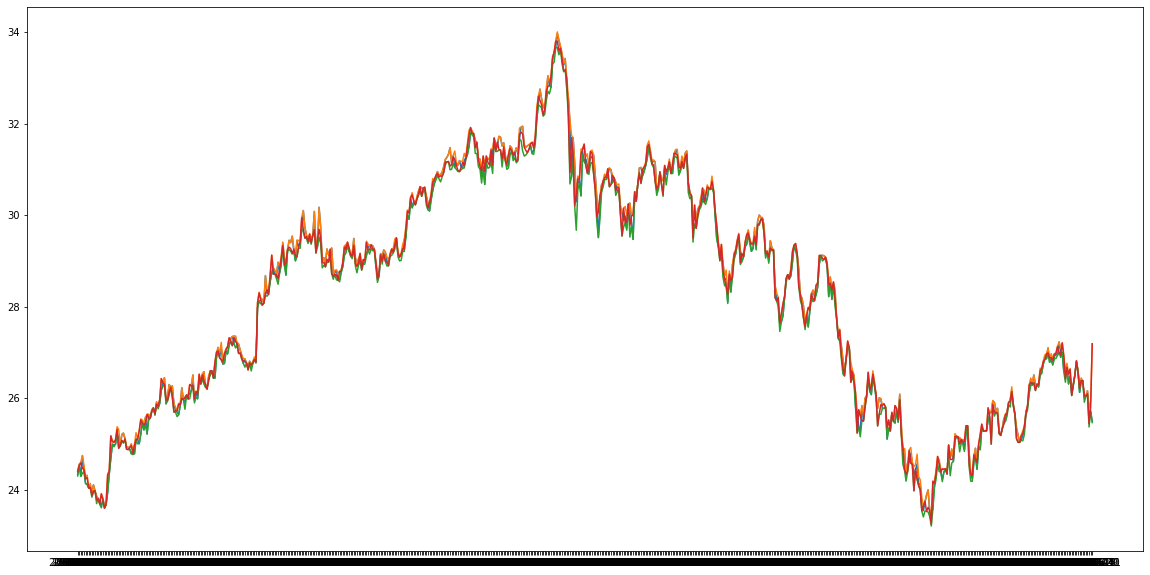

In [12]:
plt.figure(figsize=(20,10))
plt.plot(df_train['date'], df_train['open'])
plt.plot(df_train['date'], df_train['high'])
plt.plot(df_train['date'], df_train['low'])
plt.plot(df_train['date'], df_train['close'])

In [13]:
df_test = pd.DataFrame(data=testing_data)
df_test

,date,open,high,Low,close,adj_close,volume
0,2019-06-03,25.660000,25.830000,25.650000,25.825001,24.876635,10700
1,2019-06-04,26.150000,26.166000,25.889999,26.090000,25.131905,10400
2,2019-06-05,26.115999,26.115999,26.115999,26.115999,25.156948,100
3,2019-06-06,26.326000,26.326000,26.326000,26.326000,25.359238,400
4,2019-06-07,26.549999,26.600000,26.223000,26.540001,25.565380,5300
...,...,...,...,...,...,...,...
143,2019-12-24,27.990000,27.990000,27.990000,27.990000,27.668003,0
144,2019-12-26,27.980000,28.190001,27.980000,28.055000,27.732258,175900
145,2019-12-27,28.260000,28.299999,28.139999,28.139999,27.816278,2900
146,2019-12-30,28.040001,28.040001,27.700001,27.700001,27.384260,4400


In [14]:
df_test.rename(columns={'Low':'low'},inplace = True) 

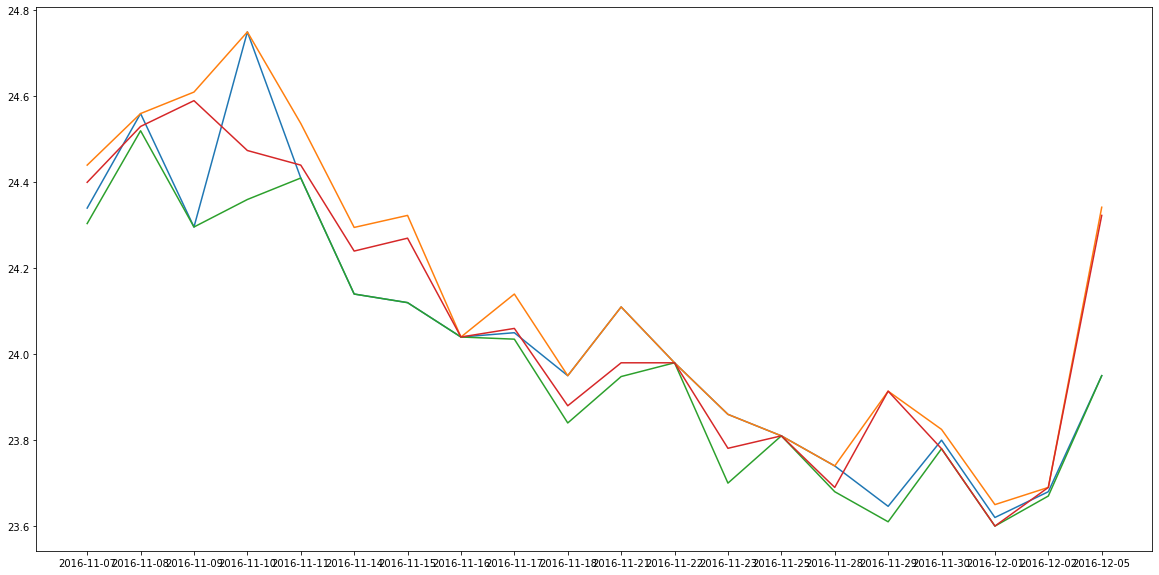

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df_train['date'][0:20], df_train['open'][0:20])
plt.plot(df_train['date'][0:20], df_train['high'][0:20])
plt.plot(df_train['date'][0:20], df_train['low'][0:20])
plt.plot(df_train['date'][0:20], df_train['close'][0:20])


####  Are there any NaN values in training and testing data sets?

In [16]:
training_count_nan = training_data.shape[0] - training_data.count()
testing_count_nan = testing_data.shape[0] - testing_data.count()
print(f"Number of NaNs in training data columns:\n{training_count_nan}")
print(f"Number of NaNs in testing data columns:\n{testing_count_nan}")

Number of NaNs in training data columns:
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64
Number of NaNs in testing data columns:
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64


#### Preprocessing the data, extracting the features, and normalising the features using `preprocessing.MinMaxScaler` function from sklearn

We have provided you with the relevant function here. But we expect you to explore the data generated. 

What are the shapes?

Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 

Optional: Extend the function to include more features - and change it 
to choose a different column as target, i.e. adj_close


In [17]:
def create_features_labels(training_data, testing_data, scaler=MinMaxScaler(feature_range = (0, 1)), sequence_length=60):
    """
    Create feature and labels from training data
    :param training_data
    :param testing_data
    :param sequence_length
    :param scaler
    :return: Features and labels sets, and labels bins
    """
    features_set = []
    labels = []
    labels_bin = []
    test_labels_bin = []
    test_features = []
    # Limiting the training and testing data to relevant column (here "open" column)
    training_data_processed = training_data.iloc[:, 1:2].values

    # Normalization: Transform features by scaling each feature in training to be in a range of (0, 1)
    training_data_processed = scaler.fit_transform(training_data_processed)
    
    # Preparing training data features and labels
    for i in range(sequence_length, len(training_data)):
        features_set.append(training_data_processed[i-sequence_length:i, 0])
        labels.append(training_data_processed[i, 0])
        # Fill binary labels if "open" rais or drope
        if training_data_processed[i,0] > training_data_processed[i-1,0]:
            labels_bin.append(1)
        else:
            labels_bin.append(0)
            
    # Preparing the testing data features
    total = pd.concat((training_data['open'], testing_data['open']), axis=0)
    test_inputs = total[len(total) - len(testing_data) - sequence_length:].values
    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)

    for i in range(sequence_length, len(test_inputs)):
        test_features.append(test_inputs[i-sequence_length:i, 0])
        # Fill binary labels if "open" rais or drope
        if test_inputs[i,0] > test_inputs[i-1,0]:
            test_labels_bin.append(1)
        else:
            test_labels_bin.append(0)
    
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    features_set, labels, labels_bin, test_labels_bin = np.array(features_set), np.array(labels), np.array(labels_bin), np.array(test_labels_bin)
    return np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1)), labels, labels_bin,test_labels_bin, test_features, scaler

In [18]:
training_data.shape,testing_data.shape

((644, 7), (148, 7))

In [19]:
features_set, labels, labels_bin, test_labels_bin, test_features, scaler = create_features_labels(training_data, testing_data, MinMaxScaler(feature_range = (0, 1)), 60)

In [20]:
features_set.shape, test_features.shape

((584, 60, 1), (148, 60, 1))

In [21]:
labels.shape, labels_bin.shape

((584,), (584,))

In [22]:
type(scaler)

sklearn.preprocessing._data.MinMaxScaler

### Model
In this section we ask you to build and train a LSTM neural network and use it predict the stock price variations on your testing data.

In [23]:
## copy from lectur
def lstm_model_1(input_shape):
    
    # TODO: Implement your model here. 
    # (Hint: Make use of `Sequential` function from tensorflow.keras to group a linear stack of layers into the model. In addition, 
    # you can apply droupouts to your input using `Dropout` from tensorflow.keras.layers)
    model = Sequential()
    model.add(LSTM(50, return_sequences = True, input_shape=(input_shape[1],1))) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(50))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.15))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    return model

def lstm_model_2(input_shape):
  model = Sequential()
  model.add(LSTM(50, return_sequences = True, input_shape=(input_shape[1],1))) 
  model.add(Dropout(0.2))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))
  # Adding the output layer
  model.add(Dense(units = 1))
  return model

#model 1

In [24]:
model_1 = lstm_model_1(features_set.shape)
#model_1.summary()

In [25]:
model_1.compile(optimizer = 'adam', loss='mean_squared_error',  metrics = ['mean_squared_error'])

In [65]:
history = model_1.fit(features_set, labels, epochs = 200, batch_size=128,verbose=1) #todo: callbacks=[mcp, rlop]
                                                                              #validation_split = 0.2,  ???

Epoch 1/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 10/100
5/5 [=============

## evaluate

In [66]:
pred_price_1 = model_1.predict(test_features)

In [67]:
pred_price_1 = model_1.predict(test_features)
pred_price_1 = scaler.inverse_transform(pred_price_1)

In [68]:
pred_price_1.shape

(148, 1)

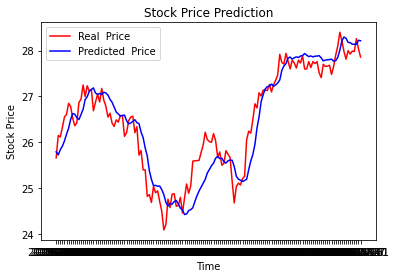

In [69]:
# TODO move curve
plt.plot(testing_data['date'],testing_data['open'], color = 'red', label = 'Real  Price')
plt.plot(testing_data['date'],pred_price_1, color = 'blue', label = 'Predicted  Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [70]:
testing_data.head(3)

,date,open,high,low,close,adj_close,volume,predict,test_labels_bin
0,2019-06-03,25.660000,25.830000,25.650000,25.825001,24.876635,10700,26.506659,1
1,2019-06-04,26.150000,26.166000,25.889999,26.090000,25.131905,10400,26.435808,1
2,2019-06-05,26.115999,26.115999,26.115999,26.115999,25.156948,100,26.474606,0


In [71]:
testing_data['predict'] = pred_price_1

In [72]:
testing_data['test_labels_bin'] = test_labels_bin

In [73]:
df_result = testing_data[['date','open','predict','test_labels_bin']]

In [74]:
df_result

,date,open,predict,test_labels_bin
0,2019-06-03,25.660000,25.792805,1
1,2019-06-04,26.150000,25.725542,1
2,2019-06-05,26.115999,25.840061,0
3,2019-06-06,26.326000,25.916178,1
4,2019-06-07,26.549999,26.029974,1
...,...,...,...,...
143,2019-12-24,27.990000,28.140200,1
144,2019-12-26,27.980000,28.138634,0
145,2019-12-27,28.260000,28.133999,1
146,2019-12-30,28.040001,28.223417,0


In [75]:
def cacl_label_bin_predict(df):
  #itterate
  previous_row = 0
  result = [0]
  
  for index, row in df.iterrows():
    if index != 0:
      if row.open > previous_row.predict:
            result.append(1)
      else:
            result.append(0)
    previous_row = row
    

  return result


In [76]:
df_result['label_bin_predict'] = cacl_label_bin_predict(df_result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
df_result

,date,open,predict,test_labels_bin,label_bin_predict
0,2019-06-03,25.660000,25.792805,1,0
1,2019-06-04,26.150000,25.725542,1,1
2,2019-06-05,26.115999,25.840061,0,1
3,2019-06-06,26.326000,25.916178,1,1
4,2019-06-07,26.549999,26.029974,1,1
...,...,...,...,...,...
143,2019-12-24,27.990000,28.140200,1,0
144,2019-12-26,27.980000,28.138634,0,0
145,2019-12-27,28.260000,28.133999,1,1
146,2019-12-30,28.040001,28.223417,0,0


# accurancy

In [78]:
sum(df_result['test_labels_bin']==df_result['label_bin_predict'])/df_result.shape[0]

0.6486486486486487

In [40]:
df_result.shape

(148, 5)

# model 2

In [41]:

model = lstm_model_2(features_set.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)               

## evaluate

Compile your model, train it and evaluate it. 

What is your mse - and what is your accuracy (note that you have two different types of labels readily available to you). 



In [42]:
#mcp = ModelCheckpoint('best_model', monitor='val_loss',save_best_only=True, verbose=1)
#rlop = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=7, verbose=1, min_lr=0.0001)

In [43]:
model.compile(optimizer = 'adam', loss='mean_squared_error',  metrics = ['mean_squared_error'])

In [44]:
history = model.fit(features_set, labels, epochs = 50, batch_size=64,verbose=1) #todo: callbacks=[mcp, rlop]
                                                                              #validation_split = 0.2,  ???

Epoch 1/50
10/10 [==============================] - 5s 15ms/step - loss: 0.1886 - mean_squared_error: 0.1886
Epoch 2/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 3/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 4/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 5/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 6/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 7/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 8/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 9/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 10/50
10/10 [

In [45]:
pred_price = model.predict(test_features)

In [46]:
pred_price = model.predict(test_features)
pred_price = scaler.inverse_transform(pred_price)

In [47]:
pred_price.shape

(148, 1)

In [48]:
testing_data

,date,open,high,low,close,adj_close,volume,predict,test_labels_bin
0,2019-06-03,25.660000,25.830000,25.650000,25.825001,24.876635,10700,26.506659,1
1,2019-06-04,26.150000,26.166000,25.889999,26.090000,25.131905,10400,26.435808,1
2,2019-06-05,26.115999,26.115999,26.115999,26.115999,25.156948,100,26.474606,0
3,2019-06-06,26.326000,26.326000,26.326000,26.326000,25.359238,400,26.501009,1
4,2019-06-07,26.549999,26.600000,26.223000,26.540001,25.565380,5300,26.564644,1
...,...,...,...,...,...,...,...,...,...
143,2019-12-24,27.990000,27.990000,27.990000,27.990000,27.668003,0,28.175041,1
144,2019-12-26,27.980000,28.190001,27.980000,28.055000,27.732258,175900,28.179235,0
145,2019-12-27,28.260000,28.299999,28.139999,28.139999,27.816278,2900,28.179901,1
146,2019-12-30,28.040001,28.040001,27.700001,27.700001,27.384260,4400,28.252419,0


In [49]:
testing_data.shape

(148, 9)

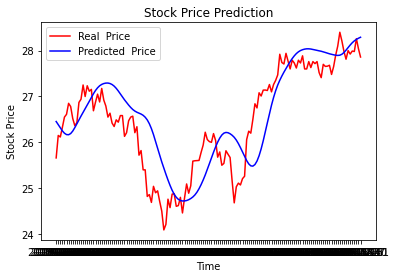

In [50]:
# TODO move curve
plt.plot(testing_data['date'],testing_data['open'], color = 'red', label = 'Real  Price')
plt.plot(testing_data['date'],pred_price, color = 'blue', label = 'Predicted  Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

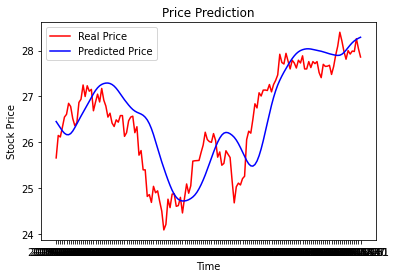

In [51]:
plt.plot(testing_data['date'],testing_data['open'], color = 'red', label = 'Real Price')
plt.plot(testing_data['date'],pred_price, color = 'blue', label = 'Predicted Price')
#plt.xticks(np.arange(0,459,50))
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

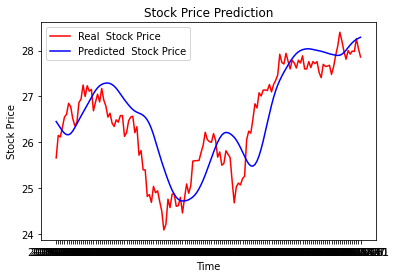

In [52]:
# epochs 50
plt.plot(testing_data['date'],testing_data['open'], color = 'red', label = 'Real  Stock Price')
plt.plot(testing_data['date'],pred_price, color = 'blue', label = 'Predicted  Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

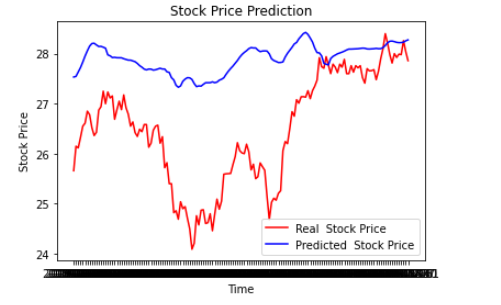

Optional: Try your model with more features, try with different sequence lengths (this is a hyperparameter) - and try with the "real" Dax Performance Index data also provided (which reaches back longer). If you do so, you will have to split the data into training and test sets first). 

# the end

# Tesla

In [53]:
df=pd.read_csv("TSLA.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [54]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

In [55]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 644):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train.shape before reshape '+str(X_train.shape))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)
X_train.shape

X_train.shape before reshape (584, 60)


(584, 60, 1)

In [56]:
type(y_train)

numpy.ndarray

In [57]:
len(X_train[0])

60

In [58]:
#input_shape = (X_train.shape[1], 1)
#input_shape

In [59]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)               

In [60]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy','mean_absolute_percentage_error'])

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
19/19 [==============================] - 5s 16ms/step - loss: 0.1425 - accuracy: 0.0041 - mean_absolute_percentage_error: 151600.0898
Epoch 2/30
19/19 [==============================] - 0s 13ms/step - loss: 0.0197 - accuracy: 0.0030 - mean_absolute_percentage_error: 175866.2323
Epoch 3/30
19/19 [==============================] - 0s 14ms/step - loss: 0.0146 - accuracy: 0.0042 - mean_absolute_percentage_error: 809641.5564
Epoch 4/30
19/19 [==============================] - 0s 14ms/step - loss: 0.0134 - accuracy: 0.0070 - mean_absolute_percentage_error: 1804834.7812
Epoch 5/30
19/19 [==============================] - 0s 15ms/step - loss: 0.0113 - accuracy: 0.0050 - mean_absolute_percentage_error: 1314438.2945
Epoch 6/30
19/19 [==============================] - 0s 14ms/step - loss: 0.0107 - accuracy: 0.0055 - mean_absolute_percentage_error: 694579.3176
Epoch 7/30
19/19 [==============================] - 0s 14ms/step - loss: 0.0128 - accuracy: 0.0041 - mean_absolute_percentage_er

In [61]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [62]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

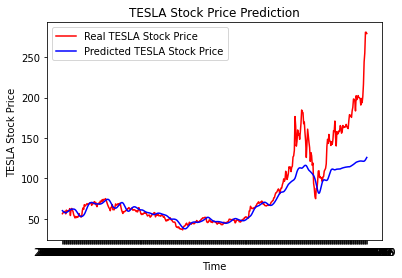

In [63]:
# Visualising the results
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

ValueError: ignored

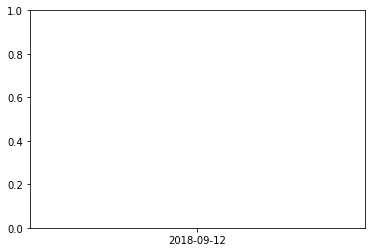

In [64]:
# Visualising the results
plt.plot(df.loc[800:850, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:850, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
#plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()